In [279]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [280]:
df = pd.read_csv('survey_results_public.csv')
df.set_index("ResponseId", inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 89184 entries, 1 to 89184
Data columns (total 83 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Q120                                 89184 non-null  object 
 1   MainBranch                           89184 non-null  object 
 2   Age                                  89184 non-null  object 
 3   Employment                           87898 non-null  object 
 4   RemoteWork                           73810 non-null  object 
 5   CodingActivities                     73764 non-null  object 
 6   EdLevel                              87973 non-null  object 
 7   LearnCode                            87663 non-null  object 
 8   LearnCodeOnline                      70084 non-null  object 
 9   LearnCodeCoursesCert                 37076 non-null  object 
 10  YearsCode                            87435 non-null  object 
 11  YearsCodePro                

Index(['18-24 years old', '25-34 years old', '35-44 years old',
       '45-54 years old', '55-64 years old', '65 years or older',
       'Prefer not to say', 'Under 18 years old'],
      dtype='object', name='Age')


(array([0.33, 1.58, 2.83, 4.08, 5.33, 6.58, 7.83, 9.08]),
 [Text(0.33, 0, '18-24 years old'),
  Text(1.58, 0, '25-34 years old'),
  Text(2.83, 0, '35-44 years old'),
  Text(4.08, 0, '45-54 years old'),
  Text(5.33, 0, '55-64 years old'),
  Text(6.58, 0, '65 years or older'),
  Text(7.83, 0, 'Prefer not to say'),
  Text(9.08, 0, 'Under 18 years old')])

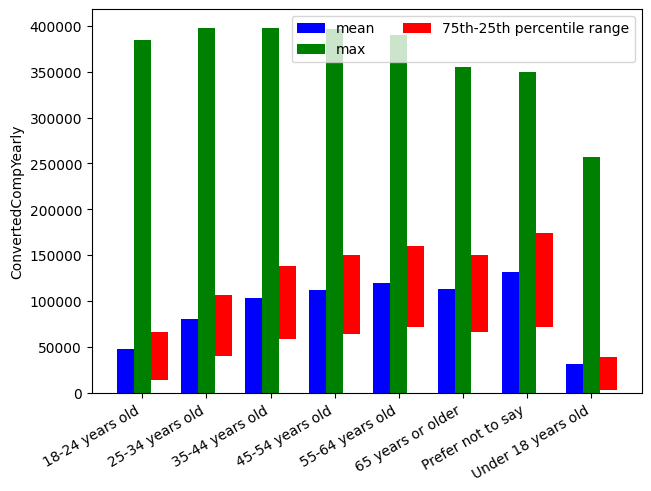

In [281]:
filtered = df[df["ConvertedCompYearly"].isna() == False]
q_hi = filtered["ConvertedCompYearly"].quantile(0.99) #get the 99th percentile (outliers, probably data errors)
filtered = filtered[filtered["ConvertedCompYearly"] < q_hi]
grouped = filtered.groupby("Age")["ConvertedCompYearly"]

indexes = grouped.mean().index
print(indexes)
bar_width = 0.33
x = np.arange(len(grouped.mean().index))
adjusted_x = x * 1.25
fig, ax = plt.subplots(layout='constrained')

bar = ax.bar(adjusted_x, grouped.mean(), bar_width, color="blue", label="mean")
max_bar = ax.bar(adjusted_x + bar_width, grouped.max(), bar_width, color="green", label="max")

q75 = grouped.quantile(0.75)
q25 = grouped.quantile(0.25)
bar_height = q75 - q25
box_bar = ax.bar(adjusted_x + bar_width*2, bar_height, bar_width, bottom=q25, color="red", label="75th-25th percentile range")

ax.legend(ncols=2, loc="upper right")
ax.set_xticks(adjusted_x + bar_width, indexes)
ax.set_ylabel('ConvertedCompYearly')
plt.xticks(rotation=30, ha="right")

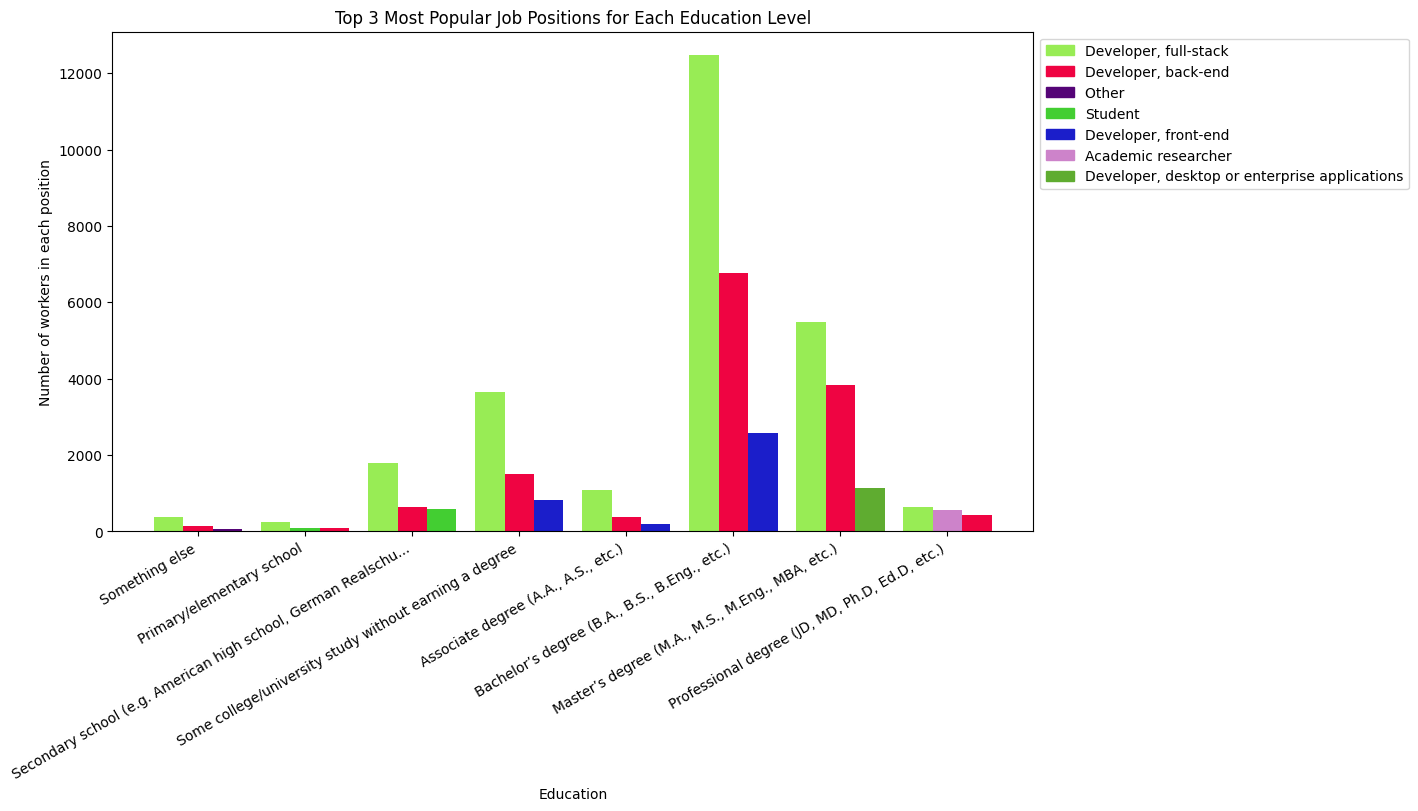

In [282]:
from matplotlib.colors import to_rgba
from matplotlib.patches import Patch
import random

custom_order = [
    'Something else', 
    'Primary/elementary school', 
    'Secondary school (e.g. American high school, German Realschule or Gymnasium, etc.)', 
    'Some college/university study without earning a degree',
    'Associate degree (A.A., A.S., etc.)',
    'Bachelor’s degree (B.A., B.S., B.Eng., etc.)',
    'Master’s degree (M.A., M.S., M.Eng., MBA, etc.)',
    'Professional degree (JD, MD, Ph.D, Ed.D, etc.)'
]
non_na_dev_types = df[df["DevType"].isna() == False]
non_na_dev_types_and_ed_levels = non_na_dev_types[non_na_dev_types['EdLevel'].isna() == False]
all_education_levels = non_na_dev_types_and_ed_levels['EdLevel'].unique()
missing_education_levels = [element for element in all_education_levels if element not in custom_order]
enhanced_custom_order = custom_order + missing_education_levels
non_na_dev_types_and_ed_levels['EdLevel'] = pd.Categorical(non_na_dev_types_and_ed_levels['EdLevel'], categories=enhanced_custom_order, ordered=True)

grouped_ed_levels = non_na_dev_types_and_ed_levels.groupby("EdLevel")

bar_width = 0.33
x = np.arange(len(grouped_ed_levels))
adjusted_x = x * 1.2

top_jobs_by_education = {}
indexes = []

for education_level, group in grouped_ed_levels:
    top_jobs = group['DevType'].value_counts().nlargest(3).index.tolist()
    top_jobs_by_education[education_level] = top_jobs
    limit = 60
    ellipsis = education_level[:limit] + ('...' if len(education_level) > limit else '')
    indexes.append(ellipsis)

fig, ax = plt.subplots(layout='constrained', figsize=(14, 8))

job_types = {
    "['Developer, full-stack']": (0.596078431372, 0.9254901960, 0.333333333, 1),
    "['Developer, back-end']": (0.9372549019, 0.01568627450, 0.2588235294, 1),
    "['Other (please specify):']":(0.333333333, 0.01568627450, 0.46666666, 1),
    "['Student']": (0.262745098, 0.8078431372, 0.19607843137, 1),
    "['Developer, front-end']": (0.1058823529, 0.117647058823, 0.79215686, 1),
    "['Academic researcher']": (0.803921568, 0.5137254901, 0.79215686274, 1),
    "['Developer, desktop or enterprise applications']": (0.3721208613689483, 0.6760034780790405, 0.18707464066071333, 1),
}

for i, (education_level, top_jobs) in enumerate(top_jobs_by_education.items()):
    education_data = grouped_ed_levels.get_group(education_level)
    job_counts = education_data['DevType'].value_counts().loc[top_jobs]
    for j in range(0,3):   
        label = str(job_counts.index[j])
        if(job_types.get(str([job_counts.index[j]]))):
            color = job_types.get(str([job_counts.index[j]]))
        else:
            color = to_rgba((random.random(), random.random(), random.random()))
            job_types[str([job_counts.index[j]])] = color
        ax.bar(adjusted_x[i] + j * bar_width, job_counts[j], bar_width, color=color, label=label)

ax.set_xlabel('Education')
ax.set_ylabel('Number of workers in each position')
ax.set_title('Top 3 Most Popular Job Positions for Each Education Level')
custom_legend = []
for key, value in job_types.items():
    custom_legend.append(Patch(color=value, label=key.replace("[\'", "").replace("\']", "").replace("(please specify):", "")))

ax.set_xticks(adjusted_x + bar_width, indexes)

plt.legend(handles=custom_legend, loc='upper left', bbox_to_anchor=(1,1))
plt.xticks(rotation=30, ha="right")
plt.show()